In [621]:
import sys
from IPython.display import display
import numpy as np
from scipy.stats import skewnorm

# check if python3 is used
if sys.version_info < (3, 0):
    print("This programs need python3x to run. Aborting.")
    sys.exit(1)

import os
import glob
import random
from PIL import Image
from math import floor

def moments2e(image):
  """
  Most of this is from:
  https://github.com/shackenberg/Image-Moments-in-Python/blob/master/moments.py
  
  This function calculates the raw, centered and normalized moments
  for any image passed as a numpy array.
  Further reading:
  https://en.wikipedia.org/wiki/Image_moment
  https://en.wikipedia.org/wiki/Central_moment
  https://en.wikipedia.org/wiki/Moment_(mathematics)
  https://en.wikipedia.org/wiki/Standardized_moment
  http://opencv.willowgarage.com/documentation/cpp/structural_analysis_and_shape_descriptors.html#cv-moments
  
  compare with:
  import cv2
  cv2.moments(image)
  """
  from numpy import mgrid, sum
    
  # need it to be gray scale first
  gray = image.convert('L')  

  image = np.asarray(gray.point(lambda x: 0 if x<1 else 255, '1'), dtype='int8')
  assert len(image.shape) == 2 # only for grayscale images        
  x, y = mgrid[:image.shape[0],:image.shape[1]]
  moments = {}
  moments['mean_x'] = sum(x*image)/sum(image)
  moments['mean_y'] = sum(y*image)/sum(image)
          
  # raw or spatial moments
  moments['m00'] = sum(image)
  moments['m01'] = sum(x*image)
  moments['m10'] = sum(y*image)
  moments['m11'] = sum(y*x*image)
  moments['m02'] = sum(x**2*image)
  moments['m20'] = sum(y**2*image)
  moments['m12'] = sum(x*y**2*image)
  moments['m21'] = sum(x**2*y*image)
  moments['m03'] = sum(x**3*image)
  moments['m30'] = sum(y**3*image)
  
  # central moments
  # moments['mu01']= sum((y-moments['mean_y'])*image) # should be 0
  # moments['mu10']= sum((x-moments['mean_x'])*image) # should be 0
  moments['mu11'] = sum((x-moments['mean_x'])*(y-moments['mean_y'])*image)
  moments['mu02'] = sum((y-moments['mean_y'])**2*image) # variance
  moments['mu20'] = sum((x-moments['mean_x'])**2*image) # variance
  moments['mu12'] = sum((x-moments['mean_x'])*(y-moments['mean_y'])**2*image)
  moments['mu21'] = sum((x-moments['mean_x'])**2*(y-moments['mean_y'])*image) 
  moments['mu03'] = sum((y-moments['mean_y'])**3*image) 
  moments['mu30'] = sum((x-moments['mean_x'])**3*image) 

    
  # opencv versions
  #moments['mu02'] = sum(image*(x-moments['m01']/moments['m00'])**2)
  #moments['mu02'] = sum(image*(x-y)**2)

  # wiki variations
  #moments['mu02'] = m20 - mean_y*m10 
  #moments['mu20'] = m02 - mean_x*m01
        
  # central standardized or normalized or scale invariant moments
  moments['nu11'] = moments['mu11'] / sum(image)**(2/2+1)
  moments['nu12'] = moments['mu12'] / sum(image)**(3/2+1)
  moments['nu21'] = moments['mu21'] / sum(image)**(3/2+1)
  moments['nu20'] = moments['mu20'] / sum(image)**(2/2+1)
  moments['nu03'] = moments['mu03'] / sum(image)**(3/2+1) # skewness
  moments['nu30'] = moments['mu30'] / sum(image)**(3/2+1) # skewness
  #print(moments)
  return moments

def orientation(moments, out_type='deg'):
    """
    Returns orientation from moments, in degrees or radians
    """
    theta = 0.5*np.arctan(2*moments['mu11']/(moments['mu20']-moments['mu02']))
    
    if (out_type == 'deg'):
        return theta*(180/np.pi)
    else:
        return theta

def initialize(backgrounds_dir, classes_dir):
    # Loading data
    backgrounds = os.listdir(backgrounds_dir)
    class_names = os.listdir(classes_dir)
    class_objects = [os.listdir(os.path.join(classes_dir,c)) for c in class_names]

    # ignore scaling for now: .resize(resolution, Image.BICUBIC)
    bgs = [Image.open(os.path.join(backgrounds_dir,b)) for b in backgrounds]

    objs = []
    for i,c in enumerate(class_objects):
        print('loading '+class_names[i]+' as '+str(i))
        print(species[class_names[i]])
        objs = objs + [[Image.open(os.path.join(classes_dir,class_names[i],o)) for o in c]]

    return objs, class_names, bgs



def rot_obj(obj):
    # straight direction is most common, augmented data should reflect this
    angle = np.random.normal(0,100)
    new_obj = obj.rotate(angle, expand=True)
    return new_obj

def scale_obj(obj, mean_size=60, max_size=103,  size_real=0, distance=0):
    # in front of image size is 1392px/339mm
    # in back of image size is 1392px/1190mm
         
    max_distance = 700
    min_distance = 200
    var_size = 0
    
    if (distance == 0):
        # cross section is trapezoid, height increases towards back of image.
        s = skewnorm.rvs(-5, size=1, loc=650,scale=120)
        s2 = (int)(np.clip(s, 200, 700))
        
        distance = random.randint(min_distance, max_distance)
    
    if (size_real == 0):
        # add some variance
        var_size = (max_size - mean_size)/3
        print(max_size, mean_size, var_size)        
        size_real = np.random.normal(mean_size, var_size)
        print('mean size = ' + str(mean_size) + ', var size = ' + str(var_size))
    
    pix_per_mm = (1392/(339 + (distance-200)*((1190-339)/(max_distance-200))))
    
    
    new_length = (int)(pix_per_mm*size_real)
    
    
    ratio = new_length/(int)(np.shape(obj)[1])
    print('distance ' +str(distance))
    
    print('pix per mm ', str(pix_per_mm))
    print('ratio ' + str(ratio))
    print('new length ' + str(new_length) + 'px, ' + str(size_real) + ' mm')    
    new_height = (int)(np.shape(obj)[0]*ratio)
    print('new height ' + str(new_height))
    
    #print(ratio, new_length, new_height)
    
    new_obj=obj.resize((new_length, new_height))
    
    return new_obj, distance

def flip_obj(obj, p_hflip=0.3, p_vflip=0.1):
    """
    randomly flip an object horizontally and/or vertically
    pflip: probability of flipping
    """
    hflip = np.random.random()
    vflip = np.random.random()
    
    if (hflip < p_hflip ):
        obj = obj.transpose(Image.FLIP_LEFT_RIGHT)
        print('flipping horizontally ' + str(hflip))
    if (vflip < p_vflip ):
        obj = obj.transpose(Image.FLIP_TOP_BOTTOM)
        print('flipping vertically' + str(vflip))
    return obj

# Simulate an image
def mkimage(filename, objs, names, bgs, maxobjs, output_dir="images_out",single=False):
    log = []
    im = bgs[random.randint(0,len(bgs)-1)].copy()
    # print('bg size='+str(im.size))
    cls0 = random.randint(0,len(objs)-1)
    n_obj = random.randint(1,maxobjs)
    img_list = []
    for c in range(0, n_obj):
        if single: cls=cls0
        else: cls = random.randint(0,len(objs)-1)
        obj = random.choice(objs[cls])        
        imx,imy = im.size
        
        # first paste to zero background, or the moment function
        # will return the wrong values
        black_bkg = Image.new('L', obj.size)
        black_bkg.paste(obj,(0,0),obj)
        
        
        
        # horizontally align objects so scaling will be appropriate
        degrees = orientation(moments2e(black_bkg))        
        obj = obj.rotate(-1*degrees,expand=True)
        
        # we probably padded it with a lot of black that will interfere with
        # so we need to get rid of this
        bbox = obj.getbbox()
        obj = obj.crop(bbox)
        
        
        sizex,sizey = obj.size
        #print(obj.size)
        if(sizey > sizex):
            print('taller than wide, rotating')
            obj = obj.rotate(-90,expand=True)
            
        # get size limitations from species dictionary
        mean_size= species[names[cls]][1][0]
        max_size= species[names[cls]][1][1]
        #print (mean_size, max_size)
        obj, distance = scale_obj(obj, mean_size, max_size) # scale to random size
        obj = rot_obj(obj) # rotate to random angle
        sizex,sizey = obj.size # update size after rotation
        obj = flip_obj(obj) # sometimes flip image
        display(obj)
        
        imx,imy = im.size
        posx = random.randint(-floor(sizex/2),imx-floor(sizex/2))
        posy = random.randint(-floor(sizey/2),imy-floor(sizey/2))
        #im.paste(obj,(posx,posy),obj) # need to do this in the right order.
        img_list.append([obj, (posx,posy), distance])
        log = log + ['{}\t{}\t{}\t{}\t{}\t{}\n'.format(names[cls],cls,posy,posx,posy+sizey,posx+sizex)]
    
    # sort images from farthest to closest
    img_list.sort(key=lambda tup: tup[2], reverse=True)
    
    # paste in the correct order
    for item in img_list:
        im.paste(item[0], item[1], item[0])
    
    im.save(os.path.join(output_dir,filename+'.png'))
    with open(os.path.join(output_dir,filename+'.txt'),'w') as f:
        for l in log: f.write(l)

# Testing
def test():
    objects, names, backgrounds = initialize(backgrounds_dir="backgrounds", classes_dir="crops")
    mkimage('test', objects, names, backgrounds, output_dir="images_out", maxobjs=6)


loading Benthosema as 0
['Benthosema Glaciale', (70, 103)]
loading BlueWhiting as 1
['Micromesistius Poutassou', (220, 550)]
loading Herring as 2
['Clupea Harengus', (300, 440)]
loading Mackerel as 3
['Scomber Scombrus', (301, 601)]
103 70 11.0
mean size = 70, var size = 11.0
distance 428
pix per mm  1.9145705420215222
ratio 0.9226519337016574
new length 167px, 87.26014788713532 mm
new height 53


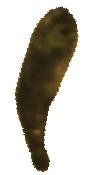

taller than wide, rotating
103 70 11.0
mean size = 70, var size = 11.0
distance 446
pix per mm  1.8371581064601448
ratio 0.831081081081081
new length 123px, 67.40209737849878 mm
new height 30
flipping horizontally 0.16903330699358832


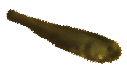

550 220 110.0
mean size = 220, var size = 110.0
distance 366
pix per mm  2.239627243649563
ratio 1.210826210826211
new length 425px, 189.8594554669081 mm
new height 405


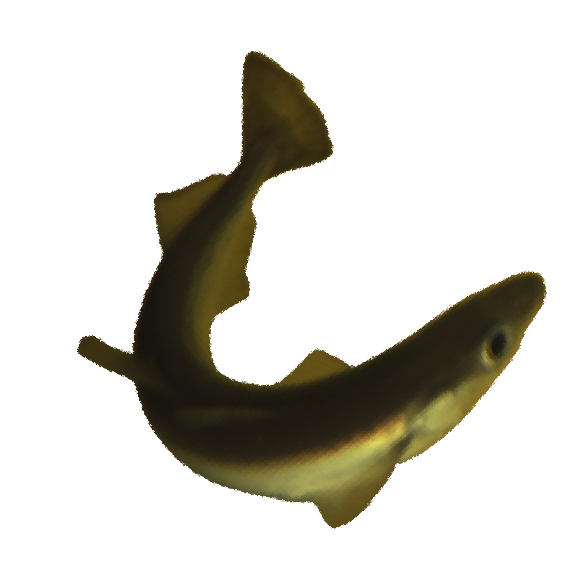

440 300 46.666666666666664
mean size = 300, var size = 46.666666666666664
distance 315
pix per mm  2.6031829147420193
ratio 1.4398073836276084
new length 897px, 344.7073807137035 mm
new height 264


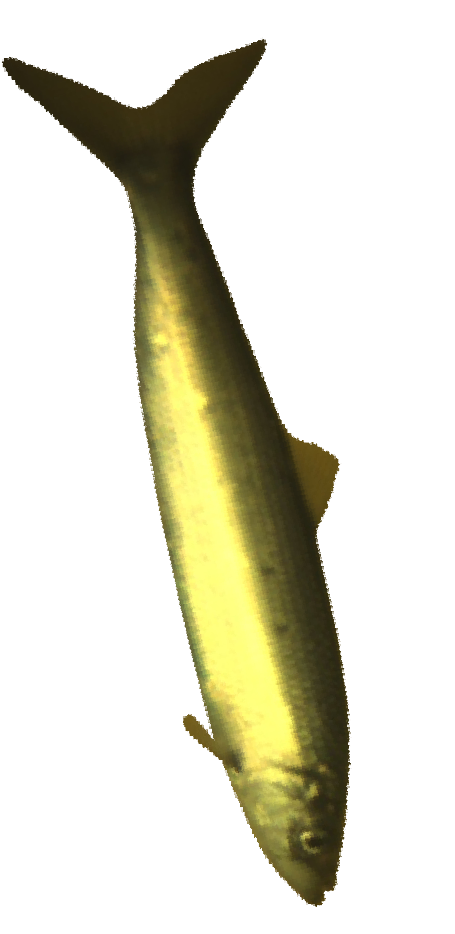

taller than wide, rotating
550 220 110.0
mean size = 220, var size = 110.0
distance 685
pix per mm  1.1953936125447628
ratio 0.9024390243902439
new length 370px, 310.295459026313 mm
new height 116


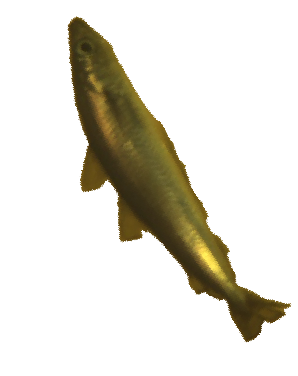

taller than wide, rotating
601 301 100.0
mean size = 301, var size = 100.0
distance 637
pix per mm  1.2855868352952695
ratio 1.0071428571428571
new length 564px, 438.93193052076606 mm
new height 211
flipping horizontally 0.2774163708817218


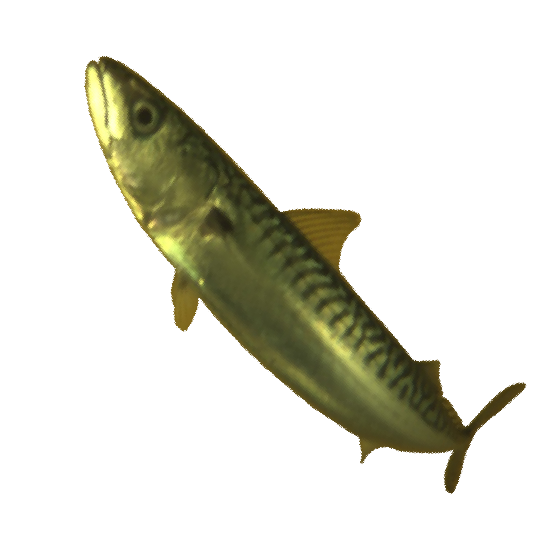

In [628]:
species = {
    "Mackerel": ['Scomber Scombrus', (301,601)],
    "Benthosema": ['Benthosema Glaciale', (70,103)],
    "BlueWhiting": ['Micromesistius Poutassou', (220,550)],
    "Herring": ['Clupea Harengus', (300,440)]
}



objects, names, backgrounds = initialize(backgrounds_dir="source_data/Backgrounds", classes_dir="source_data/Classes")
mkimage('test', objects, names, backgrounds, output_dir="images_out", maxobjs=6)



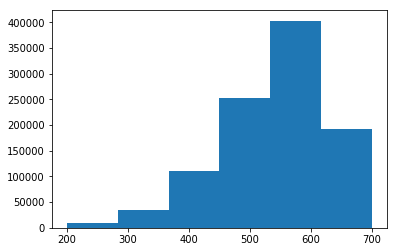

In [543]:
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

%matplotlib inline

# too high scale causes buildup of objects close to front and back
# we can accept this to some degree

s = skewnorm.rvs(-6, size=1000000, loc=650,scale=140)
s2 = (np.clip(s, 200, 700))
count, bins, ignored = plt.hist(s2, 6)
plt.show()

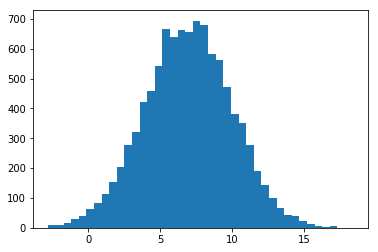

In [579]:
import matplotlib.pyplot as plt

%matplotlib inline

angle = np.random.normal(5,100,10000)
count, bins, ignored = plt.hist(angle, 40)
plt.show()